In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=3110f39b8c46ad4205c8900fac681ebd339bb38224aee608192cb5339bb721c1
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
import wandb
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

Mounted at /gdrive


In [3]:
run = wandb.init(project="7-7faces")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
config = wandb.config
wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

In [5]:
dataset_path_train = "/gdrive/MyDrive/dataset/7-7 dataset"
width = height =224

idg=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=(0.8,1.2),
    # zoom_range=0.1,
    validation_split=0.1,
)

train_data=idg.flow_from_directory(
    dataset_path_train,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training',
)
val_data=idg.flow_from_directory(
    dataset_path_train,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation',

)

Found 1227 images belonging to 14 classes.
Found 131 images belonging to 14 classes.


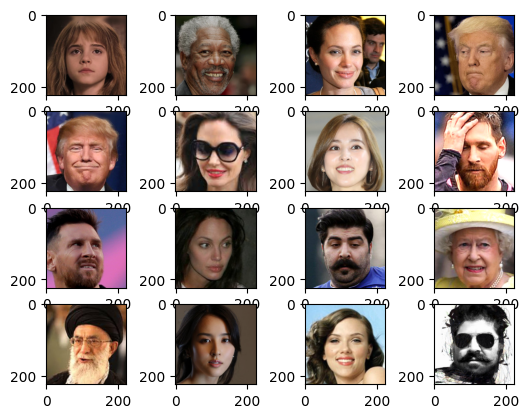

In [6]:
train_images = next(train_data)[0]
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_images[i])

In [7]:
model = tf.keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(width,height,3),
    pooling ='avg'
    )

17225924/17225924 [==============================] - 0s 0us/step


In [8]:
for layer in model.layers[0:-12]:
  layer.trainable = False

In [9]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [10]:
my_model = models.Sequential([
    model,
    # layers.Flatten(),
    layers.Dropout(0.2),
    # layers.Dense(512, activation="relu"),
    # layers.Dense(256, activation="relu"),
    # layers.Dropout(0.2),
    layers.Dense(14, activation="softmax"),
])

In [11]:
my_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.categorical_crossentropy,
              metrics = ['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint("/gdrive/MyDrive/best_model",
                                            save_best_only=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [13]:
history = my_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20 ,
    callbacks=[stop_early, checkpoint,wandb_callbacks]
    )

Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.9104

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 442s 12s/step - loss: 0.2973 - accuracy: 0.9104 - val_loss: 3.2389 - val_accuracy: 0.4046
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9935

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 33s 868ms/step - loss: 0.0393 - accuracy: 0.9935 - val_loss: 2.3824 - val_accuracy: 0.5191
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9959

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 32s 827ms/step - loss: 0.0205 - accuracy: 0.9959 - val_loss: 2.2730 - val_accuracy: 0.5496
Epoch 4/20
39/39 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9984

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 33s 867ms/step - loss: 0.0119 - accuracy: 0.9984 - val_loss: 1.1222 - val_accuracy: 0.7481
Epoch 5/20
39/39 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 31s 815ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.7063 - val_accuracy: 0.8321
Epoch 6/20
39/39 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 32s 825ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.4354 - val_accuracy: 0.9084
Epoch 7/20
39/39 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 24s 614ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.9161 - val_accuracy: 0.6107
Epoch 8/20
39/39 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 24s 626ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5302 - val_accuracy: 0.9084
Epoch 9/20
39/39 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 23s 598ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.5581 - val_accuracy: 0.8626
Epoch 10/20
39/39 [==============================] - ETA: 0s - loss: 9.9476e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 34s 869ms/step - loss: 9.9476e-04 - accuracy: 1.0000 - val_loss: 0.2995 - val_accuracy: 0.9237
Epoch 11/20
39/39 [==============================] - ETA: 0s - loss: 7.8611e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 31s 818ms/step - loss: 7.8611e-04 - accuracy: 1.0000 - val_loss: 0.2461 - val_accuracy: 0.9466
Epoch 12/20
39/39 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 32s 826ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2413 - val_accuracy: 0.9389
Epoch 13/20
39/39 [==============================] - ETA: 0s - loss: 5.8388e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 35s 905ms/step - loss: 5.8388e-04 - accuracy: 1.0000 - val_loss: 0.2192 - val_accuracy: 0.9466
Epoch 14/20
39/39 [==============================] - ETA: 0s - loss: 4.8215e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 32s 839ms/step - loss: 4.8215e-04 - accuracy: 1.0000 - val_loss: 0.1885 - val_accuracy: 0.9542
Epoch 15/20
39/39 [==============================] - ETA: 0s - loss: 3.9417e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 23s 605ms/step - loss: 3.9417e-04 - accuracy: 1.0000 - val_loss: 0.2154 - val_accuracy: 0.9466
Epoch 16/20
39/39 [==============================] - ETA: 0s - loss: 3.8630e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 23s 599ms/step - loss: 3.8630e-04 - accuracy: 1.0000 - val_loss: 0.2312 - val_accuracy: 0.9466
Epoch 17/20
39/39 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 23s 592ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3731 - val_accuracy: 0.9237
Epoch 18/20
39/39 [==============================] - ETA: 0s - loss: 5.4593e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 23s 592ms/step - loss: 5.4593e-04 - accuracy: 1.0000 - val_loss: 0.2561 - val_accuracy: 0.9466
Epoch 19/20
39/39 [==============================] - ETA: 0s - loss: 6.0100e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 21s 549ms/step - loss: 6.0100e-04 - accuracy: 1.0000 - val_loss: 0.3636 - val_accuracy: 0.9237
Epoch 20/20
39/39 [==============================] - ETA: 0s - loss: 3.8159e-04 - accuracy: 1.0000

wandb: Adding directory to artifact (./models)... Done. 0.1s


39/39 [==============================] - 25s 654ms/step - loss: 3.8159e-04 - accuracy: 1.0000 - val_loss: 0.2615 - val_accuracy: 0.9313


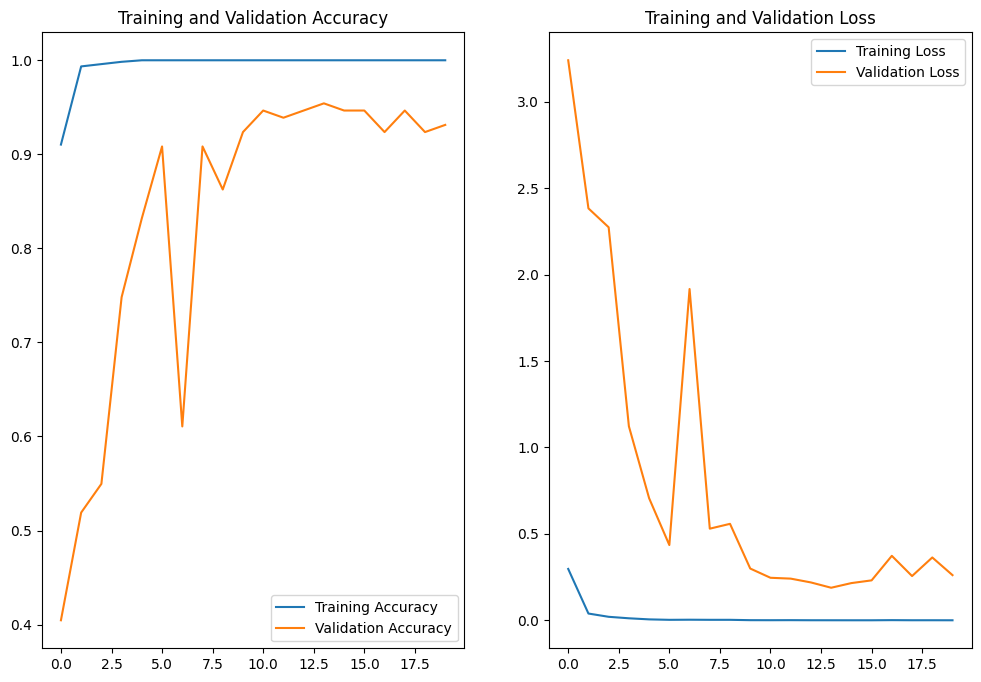

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
loaded_model = tf.keras.models.load_model('/gdrive/MyDrive/best_model')
# new_history = loaded_model.fit(train_dataset, epochs=20,
#                     validation_data=test_dataset,
#                     validation_steps=30,
#                     callbacks=[stop_early, checkpoint],
#                     )
loaded_model.evaluate(val_data)

5/5 [==============================] - 2s 258ms/step - loss: 0.2369 - accuracy: 0.9389


[0.23687219619750977, 0.9389312863349915]

In [ ]:
drive.mount('/gdrive', force_remount=True)
loaded_model.save('/gdrive/MyDrive/dataset/7_7.h5')

In [16]:
Y_true = []
Y_pred = []

for i in range(5):
    images = val_data[i][0]
    for image in images:
        image = np.expand_dims(image, axis=0)
        prediction=loaded_model.predict(image)
        Y_pred.append(np.argmax(prediction))

for i in range(5):
    labels = val_data[i][1]
    for label in labels:
        # print(np.argmax(label.tolist()))
        Y_true.append(np.argmax(label.tolist()))  # append list

1/1 [==============================] - 0s 23ms/step


['Ali_Khamenei', 'Angelina_Jolie', 'Barak_Obama', 'Behnam_Bani', 'Donald_Trump', 'Emma_Watson', 'Han_Hye_Jin', 'Kim_Jong_Un', 'Leyla_Hatami', 'Lionel_Messi', 'Michelle_Obama', 'Morgan_Freeman', 'Queen_Elizabeth', 'Scarlett_Johansson']


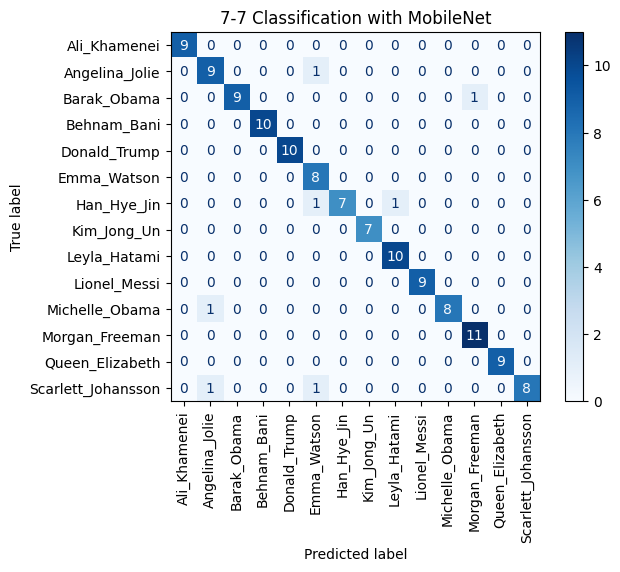

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels=[]
for i in val_data.class_indices:
  labels.append(i)
print(labels)
cm = confusion_matrix(Y_true, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues,xticks_rotation=90)
plt.title("7-7 Classification with MobileNet")
# plt.savefig('output/confusionmatric_floweraug.jpg')
plt.show()

In [18]:
import cv2
import numpy as np

drive.mount('/gdrive', force_remount=True)
model11 = tf.keras.models.load_model('/gdrive/MyDrive/dataset/7_7.h5')

Mounted at /gdrive


In [20]:
dataset_path_test = "/gdrive/MyDrive/dataset/test_images"

idg=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

test_data=idg.flow_from_directory(
    dataset_path_test,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training',
)


Found 14 images belonging to 14 classes.


In [21]:
Y_testtrue = []
Y_testpred = []

label_show = ['Ali_Khamenei', 'Angelina_Jolie', 'Barak_Obama', 'Behnam_Bani', 'Donald_Trump', 'Emma_Watson', 'Han_Hye_Jin', 'Kim_Jong_Un', 'Leyla_Hatami', 'Lionel_Messi', 'Michelle_Obama', 'Morgan_Freeman', 'Queen_Elizabeth', 'Scarlett_Johansson']

for i in range(1):
    images = test_data[i][0]
    # print(len(labels))
    for image in images:
        # X.append(image)                    # append tensor
        image = np.expand_dims(image, axis=0)
        prediction=loaded_model.predict(image)
        Y_testpred.append(np.argmax(prediction))

for i in range(1):
    labels = test_data[i][1]
    for label in labels:
        Y_testtrue.append(np.argmax(label.tolist()))  # append list
for i,j in zip(Y_testtrue,Y_testpred):
    print(f'real picture:  {label_show[i]}    ======>     predicte picture:  {label_show[j]}\n')


1/1 [==============================] - 0s 20ms/step
real picture:  Lionel_Messi    ======>     predicte picture:  Lionel_Messi

real picture:  Ali_Khamenei    ======>     predicte picture:  Ali_Khamenei

real picture:  Scarlett_Johansson    ======>     predicte picture:  Scarlett_Johansson

real picture:  Han_Hye_Jin    ======>     predicte picture:  Han_Hye_Jin

real picture:  Behnam_Bani    ======>     predicte picture:  Behnam_Bani

real picture:  Barak_Obama    ======>     predicte picture:  Barak_Obama

real picture:  Leyla_Hatami    ======>     predicte picture:  Leyla_Hatami

real picture:  Queen_Elizabeth    ======>     predicte picture:  Queen_Elizabeth

real picture:  Morgan_Freeman    ======>     predicte picture:  Morgan_Freeman

real picture:  Emma_Watson    ======>     predicte picture:  Scarlett_Johansson

real picture:  Donald_Trump    ======>     predicte picture:  Donald_Trump

real picture:  Kim_Jong_Un    ======>     predicte picture:  Kim_Jong_Un

real picture:  Mi